In [1]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name() # Check whether GPU is available

2.8.0


'/device:GPU:0'

**Import Dataset from gdrive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


**Import Libraries**

In [35]:
# Libraries for do visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for do computational things
import numpy as np
import pandas as pd


import datetime
import os
# For read the image
import glob as gb

# For evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# from tensorflow.keras.applications.mobilenetv2
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint

**Extract Datset**

In [4]:
from tqdm import tqdm
import zipfile

with zipfile.ZipFile('/content/gdrive/MyDrive/Dataset/Cats-and-Dogs-Breed-Clasification.zip','r') as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, '/content/Dataset')
        except zipfile.error as e:
            pass

Extracting : 100%|██████████| 2025/2025 [00:03<00:00, 644.67it/s]


**Check inside Datast**

In [5]:
DATASET_PATH = '/content/Dataset/Cats and Dogs Breed Clasification'

os.listdir(DATASET_PATH)

['train', 'test']

In [6]:
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
TEST_DIR = os.path.join(DATASET_PATH, 'test')

In [8]:
import glob as gb
def img_count_in_dataset(FOLDER_PATH):  
  print('-'*80)
  for folder in os.listdir(FOLDER_PATH):
    files=gb.glob(pathname=str(FOLDER_PATH + '/' + folder + '/*.jpg'))
    print(f'{len(files):4} gambar yang ditemukan di dalam folder {folder}')
  print('-'*80)

In [9]:
print("TRAIN DIR")
img_count_in_dataset(TRAIN_DIR)

TRAIN DIR
--------------------------------------------------------------------------------
 150 gambar yang ditemukan di dalam folder Pug
 150 gambar yang ditemukan di dalam folder Shiba Inu
 150 gambar yang ditemukan di dalam folder Persian
 150 gambar yang ditemukan di dalam folder Beagle
 150 gambar yang ditemukan di dalam folder Pomeranian
 150 gambar yang ditemukan di dalam folder Abyssinian
 150 gambar yang ditemukan di dalam folder Chihuahua
 150 gambar yang ditemukan di dalam folder Siamese
 150 gambar yang ditemukan di dalam folder British Shorthair
 150 gambar yang ditemukan di dalam folder Bombay
--------------------------------------------------------------------------------


In [10]:
print("TEST DIR")
img_count_in_dataset(TEST_DIR)

TEST DIR
--------------------------------------------------------------------------------
  50 gambar yang ditemukan di dalam folder Pug
  50 gambar yang ditemukan di dalam folder Shiba Inu
  50 gambar yang ditemukan di dalam folder Persian
  50 gambar yang ditemukan di dalam folder Beagle
  50 gambar yang ditemukan di dalam folder Pomeranian
  50 gambar yang ditemukan di dalam folder Abyssinian
  50 gambar yang ditemukan di dalam folder Chihuahua
  50 gambar yang ditemukan di dalam folder Siamese
  50 gambar yang ditemukan di dalam folder British Shorthair
  50 gambar yang ditemukan di dalam folder Bombay
--------------------------------------------------------------------------------


In [6]:
class_names = sorted(os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/train'))
print(class_names)

['Abyssinian', 'Beagle', 'Bombay', 'British Shorthair', 'Chihuahua', 'Persian', 'Pomeranian', 'Pug', 'Shiba Inu', 'Siamese']


In [7]:
def list_dir(class_names, slice='train'):
  return os.listdir('/content/Dataset/Cats and Dogs Breed Clasification/{}/{}'.format(slice, class_names))

for i in class_names:
  print(i)
  print(len(list_dir(i, 'train')))
  print(len(list_dir(i, 'test')))

Abyssinian
153
50
Beagle
150
50
Bombay
150
50
British Shorthair
150
50
Chihuahua
150
50
Persian
150
50
Pomeranian
150
50
Pug
150
50
Shiba Inu
150
50
Siamese
150
50


**Visualization Image**

In [17]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 9
ncols = 6

pic_index = 0 # Index for iterating over images

**Image Preprocessing**

In [8]:
train_path = '/content/Dataset/Cats and Dogs Breed Clasification/train'
test_path = '/content/Dataset/Cats and Dogs Breed Clasification/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2, 
    horizontal_flip=True, 
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

val_set = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16,
    color_mode='rgb'
)

breed_dict = train_set.class_indices
print(breed_dict)

Found 1500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
{'Abyssinian': 0, 'Beagle': 1, 'Bombay': 2, 'British Shorthair': 3, 'Chihuahua': 4, 'Persian': 5, 'Pomeranian': 6, 'Pug': 7, 'Shiba Inu': 8, 'Siamese': 9}


In [9]:
# # Create variabel X_train and y_train
X_train, y_train = train_set.next()

# Create variabel X_val and y_val
X_val, y_val = val_set.next()

In [13]:
X_train.shape

(30, 224, 224, 3)

In [14]:
class_dict = {v : k for k, v in train_set.class_indices.items()}

def plotimgs(X, y):
  labels=[]
  y_label = np.argmax(y, axis=1)
  
  for label in y_label:
    labels.append(class_dict[label])

  for idx in range(0,10):
      plt.figure(figsize=(5, 5))
      plt.imshow(X[idx])
      plt.title(labels[idx])

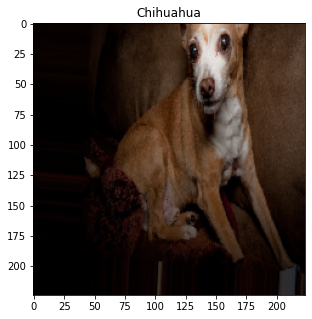

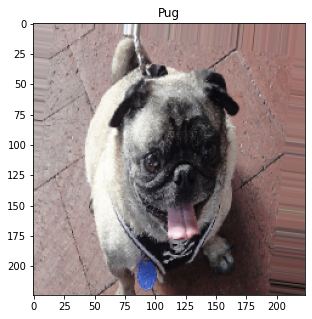

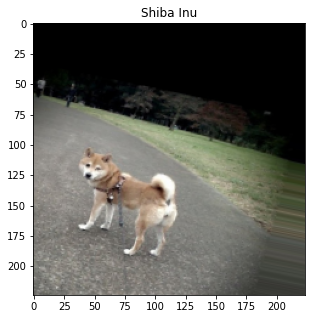

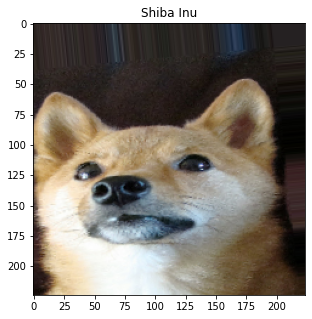

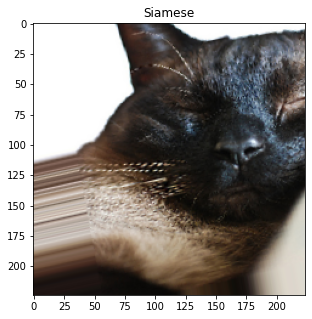

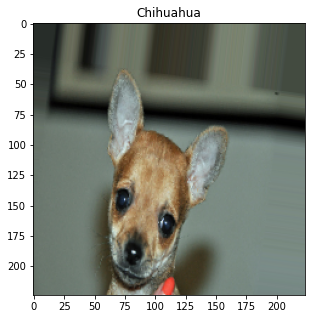

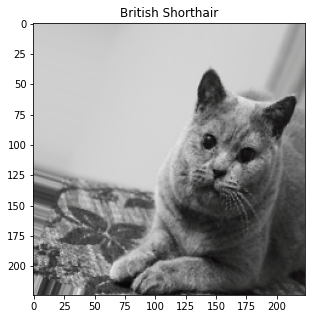

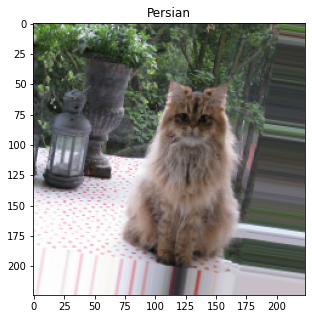

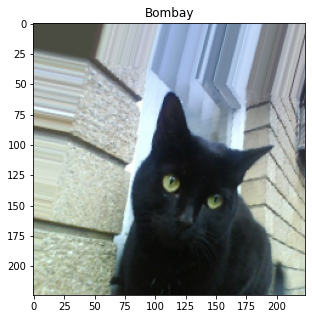

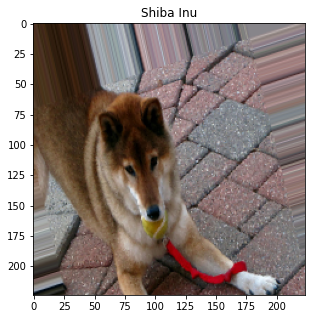

In [15]:
plotimgs(X_train, y_train)

**Evaluate models**

In [16]:
val_set.class_indices

{'Abyssinian': 0,
 'Beagle': 1,
 'Bombay': 2,
 'British Shorthair': 3,
 'Chihuahua': 4,
 'Persian': 5,
 'Pomeranian': 6,
 'Pug': 7,
 'Shiba Inu': 8,
 'Siamese': 9}

In [17]:
def evaluate_model(model, X, y):
  print('Loss of the model is - ', model.evaluate(X, y)[0])
  print('Accuracy of the model is - ', model.evaluate(X, y)[1]*100, '%')
  predict = model.predict(X)
  # print(predict)
  predict = np.argmax(predict, axis=1)
  predict = predict.reshape(1, -1)[0]
  y_label = np.argmax(y, axis=1)
  print(classification_report(y_label, predict, target_names =['Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese']))

  conf_matrix = confusion_matrix(y_label, predict)
  # print(conf_matrix)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in ('Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese')],
                  columns = [i for i in ('Abyssinian','Beagle', 'Bombay','British Shorthair','Chihuahua','Persian', 'Pomeranian','Pug', 'Shiba Inu','Siamese')])
  plt.figure(figsize = (3, 3))
  sns.heatmap(df_cm, annot=True)

plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'green')
  val_acc_plot, = plt.plot(epochs, val_acc, 'red')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'orange')
  val_loss_plot, = plt.plot(epochs, val_loss, 'blue')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_hist(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)

# **Model Building**

Using Transfer Learning to reduce training time, and improve accuracy

**Creating Callbacks**

In [36]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-8)
early_stop_cb = EarlyStopping(patience=10,monitor='val_loss', restore_best_weights= True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Clear any logs from previous runs
!rm -rf ./logs/ 

callbacks =[reduce_lr, early_stop_cb, tensorboard_callback]


In [33]:
base_model=MobileNetV2(weights='imagenet',input_shape=(224, 224, 3),include_top=False) #imports the MobileNetV2 model and discards the last 1000 neuron layer.
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(10,activation='softmax')(x) #final layer with softmax activation for N classes

model=Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs

In [34]:
for layer in base_model.layers:
  layer.trainable = False
optimizer=Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [37]:
# Trains for 20 epochs
history = model.fit(train_set,
                    epochs=15,
                    validation_data = val_set,
                    verbose = 1,
                    shuffle=True,
                    callbacks=callbacks,)

Epoch 1/15
50/50 [==============================] - 28s 520ms/step - loss: 0.5729 - accuracy: 0.8287 - val_loss: 0.3917 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 2/15
50/50 [==============================] - 26s 515ms/step - loss: 0.1664 - accuracy: 0.9440 - val_loss: 0.2713 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 3/15
50/50 [==============================] - 25s 508ms/step - loss: 0.1648 - accuracy: 0.9473 - val_loss: 0.4403 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 4/15
50/50 [==============================] - 26s 520ms/step - loss: 0.1455 - accuracy: 0.9540 - val_loss: 0.3157 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 5/15
50/50 [==============================] - 25s 510ms/step - loss: 0.0960 - accuracy: 0.9687 - val_loss: 0.3216 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 6/15
50/50 [==============================] - 26s 513ms/step - loss: 0.1138 - accuracy: 0.9633 - val_loss: 0.4567 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 7/15
50/50 [==============================] - 25s 505ms/st

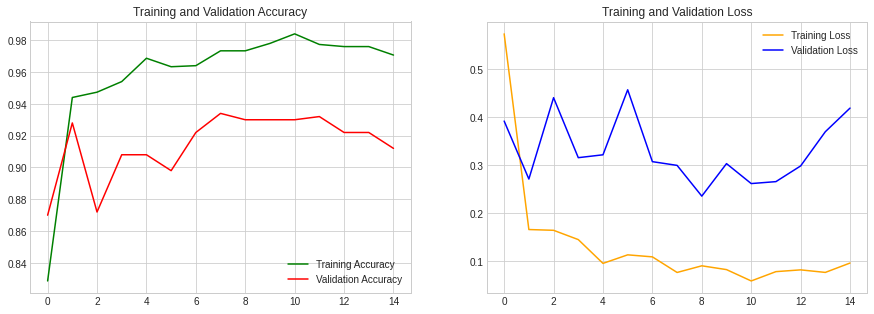

In [38]:
plot_hist(history)

1/1 [==============================] - 1s 1s/step - loss: 0.3748 - accuracy: 0.9375
Loss of the model is -  0.3747718930244446
1/1 [==============================] - 0s 51ms/step - loss: 0.3748 - accuracy: 0.9375
Accuracy of the model is -  93.75 %
                   precision    recall  f1-score   support

       Abyssinian       1.00      1.00      1.00         1
           Beagle       1.00      1.00      1.00         1
           Bombay       1.00      1.00      1.00         1
British Shorthair       0.67      1.00      0.80         2
        Chihuahua       1.00      1.00      1.00         1
          Persian       1.00      1.00      1.00         2
       Pomeranian       1.00      1.00      1.00         1
              Pug       1.00      1.00      1.00         2
        Shiba Inu       1.00      0.75      0.86         4
          Siamese       1.00      1.00      1.00         1

         accuracy                           0.94        16
        macro avg       0.97      0.97   

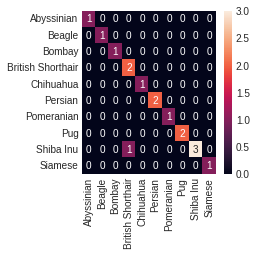

In [39]:
evaluate_model(model, X_val, y_val)

In [62]:
test_dir = '/content/Dataset/Cats and Dogs Breed Clasification/test'

for breed in breed_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, breed))    
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/Dataset/Cats and Dogs Breed Clasification/test/{breed}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        breed_list = list(breed_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_breed = breed_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_breed == breed:
            correct_count += 1
    
    print(f'{breed} Predictions --> {correct_count}/50 correct')


Abyssinian Predictions --> 43/50 correct
Beagle Predictions --> 47/50 correct
Bombay Predictions --> 49/50 correct
British Shorthair Predictions --> 44/50 correct
Chihuahua Predictions --> 47/50 correct
Persian Predictions --> 39/50 correct
Pomeranian Predictions --> 50/50 correct
Pug Predictions --> 49/50 correct
Shiba Inu Predictions --> 39/50 correct
Siamese Predictions --> 49/50 correct


In [43]:
from keras.preprocessing import image
print(sorted(class_names))

tests = [
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_166.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_183.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/British Shorthair/British_Shorthair_182.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/British Shorthair/British_Shorthair_187.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Persian/Persian_185.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Persian/Persian_189.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Pomeranian/pomeranian_158.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Shiba Inu/shiba_inu_157.jpg',
         '/content/Dataset/Cats and Dogs Breed Clasification/test/Siamese/Siamese_178.jpg',
         ]

predict_result = []
predict_result2 = []
percent = []
percent2 = []

for fn in tests:
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224,224), interpolation="nearest")
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0
  images = np.vstack([x])
  classes = model.predict(images)
  print(fn)
  predict_result.append(np.argmax(classes))
  percent.append(max(classes[0]))

['Abyssinian', 'Beagle', 'Bombay', 'British Shorthair', 'Chihuahua', 'Persian', 'Pomeranian', 'Pug', 'Shiba Inu', 'Siamese']
/content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_166.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_183.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/British Shorthair/British_Shorthair_182.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/British Shorthair/British_Shorthair_187.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Persian/Persian_185.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Persian/Persian_189.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Pomeranian/pomeranian_158.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Shiba Inu/shiba_inu_157.jpg
/content/Dataset/Cats and Dogs Breed Clasification/test/Siamese/Siamese_178.jpg


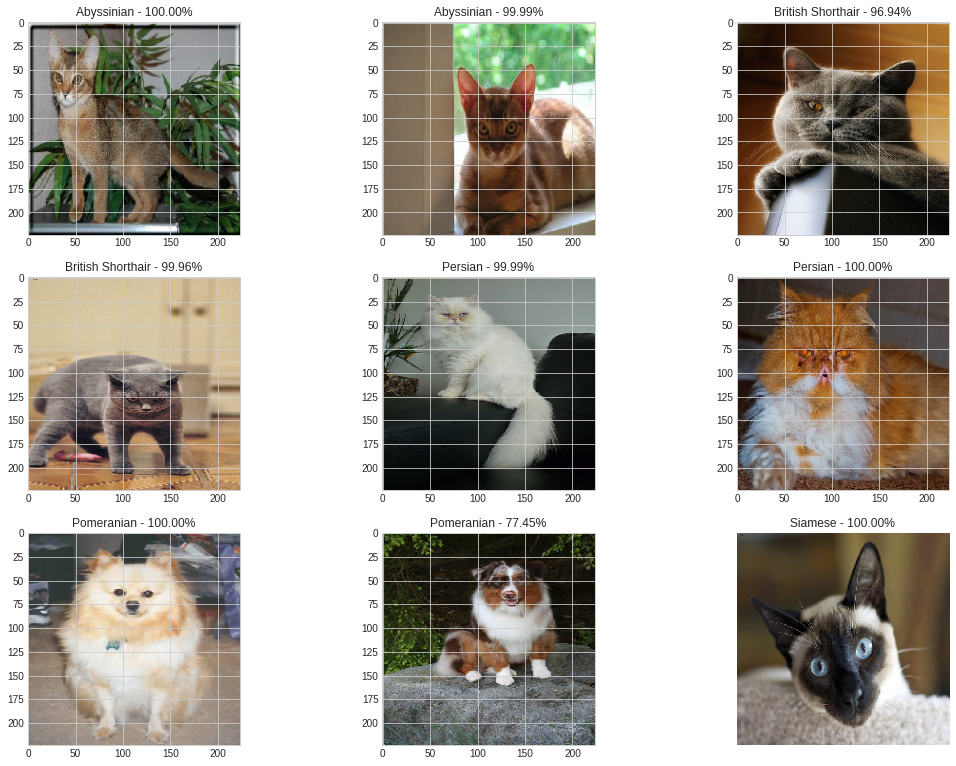

In [44]:
plt.figure(figsize=(18, 18))

num_index = 0
for images in tests:
  plt.subplot((len(tests)/3)+1, 3, num_index+1)
  plt.imshow(image.load_img(images, color_mode="rgb", target_size=(224,224), interpolation="nearest"))
  plt.title("{} - {:0.2f}%".format(class_names[predict_result[num_index]], percent[num_index]*100))
  num_index += 1
plt.axis('off')
plt.show()

In [48]:
from google.colab import files
def save_model_func(model_var, model_name):
  os.chdir('/content')
  try:
    os.mkdir('models')
  except:
    pass
  model_var.save('models/{}'.format(model_name))

  converter = tf.lite.TFLiteConverter.from_saved_model('models/{}'.format(model_name))

  lab_datagen = ImageDataGenerator(
    rescale=1./255
  )

  lab_flow = lab_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
  )

  def representative_data_gen():
    for _ in range(300):
      img_with_label = lab_flow.next() # it returns (image and label) tuple
      yield [np.array(img_with_label[0], dtype=np.float32, ndmin=2)] # return only image
    
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # converter.representative_dataset = representative_data_gen
  # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  # converter.inference_input_type = tf.uint8
  # converter.inference_output_type = tf.uint8

  tflite_model = converter.convert()

  with open('{}.tflite'.format(model_name), 'wb') as f:
    f.write(tflite_model)

  files.download('{}.tflite'.format(model_name))

  with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

  files.download('labels.txt')
  return tflite_model

In [49]:
lite_model = save_model_func(model, 'catdogsclasifier')

INFO:tensorflow:Assets written to: models/catdogsclasifier/assets


INFO:tensorflow:Assets written to: models/catdogsclasifier/assets


Found 500 images belonging to 10 classes.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
!zip -r /content/catsdogsclasifier.zip /content/models/catdogsclasifier

  adding: content/models/catdogsclasifier/ (stored 0%)
  adding: content/models/catdogsclasifier/variables/ (stored 0%)
  adding: content/models/catdogsclasifier/variables/variables.index (deflated 77%)
  adding: content/models/catdogsclasifier/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/catdogsclasifier/saved_model.pb (deflated 91%)
  adding: content/models/catdogsclasifier/assets/ (stored 0%)
  adding: content/models/catdogsclasifier/keras_metadata.pb (deflated 95%)


In [63]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Dataset/catdogsclasifier')
lite_model = tf.lite.Interpreter(model_path='/content/gdrive/MyDrive/Dataset/catdogsclasifier.tflite')

In [66]:
# interpreter = tf.lite.Interpreter(model_content=lite_model)
interpreter = lite_model

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = []

lab_datagen = ImageDataGenerator(
   rescale=1./255
)

lab_flow = lab_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
)
test_labels, test_imgs = [], []
for _ in range(10):
  image_file = list(lab_flow.next())
  test_imgs.append(image_file[0])
  print(image_file[1])
  test_labels.append(np.argmax(image_file[1]))

  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details['quantization']
    image_file[0] = image_file[0] / input_scale + input_zero_point
  
  image_file[0] = image_file[0].astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], image_file[0])
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])[0]
  predictions.append(output)

Found 500 images belonging to 10 classes.
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [67]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
        
    plt.xlabel("{} {:0.2f}% ({})".format(class_names[predicted_label],
                                         np.max(predictions_array)*100,
                                         class_names[true_label]))

<class 'numpy.int64'> <class 'numpy.int64'>


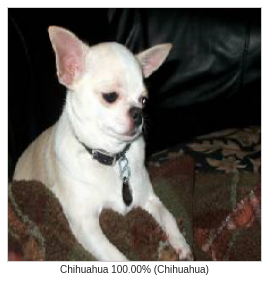

In [101]:
#@title Visualize the outputs { run: "auto" }
index = 4 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [ ]:
import tensorflow as tf
from google.colab import files
import numpy as np
from keras.preprocessing import image

files.upload()

In [89]:
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/MyDrive/Dataset/catdogsclasifier.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 224 224   3] <class 'numpy.float32'>

1 output(s):
[ 1 10] <class 'numpy.float32'>


In [92]:
from google.colab import drive
import tensorflow as tf

drive.mount('/gdrive')

model = tf.keras.models.load_model('/content/models/catdogsclasifier')
model.save_weights('catsdogsclasifiermod')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
